# Imports

In [717]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import shap


In [718]:
import numpy as np
import pandas as pd
from sklearn.metrics import explained_variance_score

pd.options.display.float_format = '{:.4f}'.format

def drop_high_correlation(X, threshold=0.95):
    # drop highly correlated features

    corr_matrix = pd.DataFrame(X).corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

    # So we are selecting the columns which are having absolute correlation greater than 0.95 and making a list of those columns named 'dropping_these_features'.
    dropping_these_features = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    X = X.drop(columns=dropping_these_features)

    return X

def drop_x_riskiest_features(df, number_to_drop=10, rolling_window=10, target_column=''):
    correlations = pd.DataFrame()
    columns = df.columns
    
    for column in columns:
        correlations[column] = df[target_column].rolling(rolling_window).corr(df[column])
    to_drop = correlations.std().sort_values(ascending=False).head(number_to_drop).keys()
    
    df.drop(columns=to_drop, inplace=True)
    return df

def get_vol(prices, span=10, delta=pd.Timedelta(days=1)):

    Delta = delta
    # 1. compute returns of the form p[t]/p[t-1] - 1
    # 1.1 find the timestamps of p[t-1] values
    df0 = prices.index.searchsorted(prices.index - delta)
    df0 = df0[df0 > 0]

    # 1.2 align timestamps of p[t-1] to timestamps of p[t]
    df0 = pd.Series(prices.index[df0-1],    
           index=prices.index[prices.shape[0]-df0.shape[0] : ])

    # 1.3 get values by timestamps, then compute returns
    df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1

    # 2. estimate rolling standard deviation
    df0 = df0.ewm(span=span).std()

    return df0

def get_barriers(daily_volatility, prices, t_final = 5, upper_lower_multipliers = [1.5, 1.5]):

    #create a container
    barriers = pd.DataFrame(columns=['datapoints_passed', 
            'price', 'vert_barrier', \
            'top_barrier', 'bottom_barrier'], \
              index = daily_volatility.index)

    for datapoint, vol in daily_volatility.iteritems():

        datapoints_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : datapoint])

        #set the vertical barrier 
        if (datapoints_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                datapoints_passed + t_final]
        else:
            vert_barrier = np.nan

        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[datapoint] + prices.loc[datapoint] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)

        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[datapoint] - prices.loc[datapoint] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)

        barriers.loc[datapoint, ['datapoints_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
        datapoints_passed, prices.loc[datapoint], vert_barrier, top_barrier, bottom_barrier

    return barriers

def get_labels(barriers):
    barriers["label_barrier"] = None
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):

            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]

            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]

            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
              top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
              bottom_barrier).any()

            #assign the labels
            if condition_pt: 
                barriers['label_barrier'][i] = 1 # Top
            elif condition_sl: 
                barriers['label_barrier'][i] = 0 # Bottom  
            else: 
                barriers['label_barrier'][i] = 0.5 # time barrier

    return barriers


def SFI(featNames, split_model, training_data, train_split_index, test_split_index): 
    imp=pd.DataFrame(columns=['score'])
    for featName in featNames:
        split_model.fit(training_data.loc[train_split_index, featName].values.reshape(-1,1),
                    training_data.loc[train_split_index,
                                        ['target']].values.reshape(-1,1))
        y_pred = split_model.predict(training_data.loc[test_split_index, featName].values.reshape(-1,1))
        imp.loc[featName,'score']= explained_variance_score(training_data.loc[test_split_index, 'target'].values.reshape(-1,1), y_pred)
    return imp

In [719]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Data loading

In [720]:
ML_FILE = "ml_trades_adj_10"
fin_ratios_file = "wrds_finratio.csv"
industry_ratios_file = "wrds_industry.csv"

In [721]:
df = pd.read_csv(f"data/{ML_FILE}.csv")
fin_ratios = pd.read_csv(f"data/{fin_ratios_file}")
industry_ratios = pd.read_csv(f"data/{industry_ratios_file}")

In [722]:
df['profit'] = df['profit'] - 2
df['profit_binary'] = df['profit'].apply(lambda x: 1 if x > 0 else 0)

In [723]:
df.profit.describe()

count   119793.0000
mean       -20.8064
std        101.4931
min       -141.4073
25%       -102.0000
50%       -102.0000
75%         52.2615
max       4081.4427
Name: profit, dtype: float64

In [724]:
gics_mapping = {
    'Communication Services': 50,
    'Consumer Discretionary': 25,
    'Consumer Staples': 30,
    'Energy': 10,
    'Financials': 40,
    'Health Care': 35,
    'Industrials': 20,
    'Information Technology': 45,
    'Materials': 15,
    'Utilities': 55,
    'Real Estate': 60
}
industry_ratios['gicdesc'] = industry_ratios['gicdesc'].replace(gics_mapping)


In [725]:
last_four_columns = df.iloc[:, -4:]

# Display the selected columns
print(last_four_columns.columns.values)

['cusip' 'rv' 'exit_date' 'trade_length']


In [726]:
pd.read_csv(f'data/meta/{535555106}.csv')

,conm,gvkey,add1,add2,add3,add4,addzip,busdesc,cik,city,conml,costat,county,dlrsn,ein,fax,fic,fyrc,ggroup,gind,gsector,gsubind,idbflag,incorp,loc,naics,phone,prican,prirow,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,LINDSAY CORP,14954,"18135 Burke Street, Suite 100",NaN,NaN,NaN,68022,"Lindsay Corporation, together with its subsidi...",836157,Omaha,Lindsay Corp,A,NaN,NaN,47-0554096,402 829 6834,USA,8.0000,2010,201060,20,20106015,D,DE,USA,333111,402 829 6800,NaN,NaN,1,3523,357.0000,925.0000,B,NE,0.0000,www.lindsay.com,NaN,1988-10-12


In [727]:
# names = []
# codes = []
# for cusip in df.cusip.values:
#     try:
#         meta = pd.read_csv(f'data/meta/{cusip}.csv')
#         conm = meta.iloc[0].gvkey
#         code = meta.iloc[0].gsector
#         names.append(conm)
#         codes.append(code)
#     except:
#         names.append('Unknown')
#         codes.append('Unknown')      
# df['gvkey'] = names
# df['gsector'] = codes

In [728]:
# with open('data/names.txt', 'w') as file:
#     for name in names:
#         file.write(f"{name}\n")
        
# with open('data/codes.txt', 'w') as file:
#     for code in codes:
#         file.write(f"{code}\n")


In [729]:
with open('data/names.txt', 'r') as file:
    names = [line.strip() for line in file.readlines()]
df['gvkey'] = names
df['gvkey'] = pd.to_numeric(df['gvkey'], errors='coerce').fillna(-1).astype(int)

with open('data/codes.txt', 'r') as file:
    codes = [line.strip() for line in file.readlines()]
df['gsector'] = codes
df['gsector'] = pd.to_numeric(df['gsector'], errors='coerce').fillna(-1).astype(int)


In [730]:
cusip_to_gvkey = dict(zip(fin_ratios['cusip'], fin_ratios['gvkey']))

fin_ratios.drop(columns=['cusip'], inplace=True)


In [731]:
# Calculate the unique cusips in df and fin_ratios
unique_cusips_df = df['gvkey'].unique()
unique_cusips_fin_ratios = fin_ratios['gvkey'].unique()

# Calculate the percentage of cusips from fin_ratios that are in df
cusips_in_df_from_fin_ratios = len(set(unique_cusips_fin_ratios).intersection(unique_cusips_df))
total_unique_cusips_df = len(unique_cusips_df)

percentage_cusips_in_df_from_fin_ratios = (cusips_in_df_from_fin_ratios / total_unique_cusips_df) * 100
print(f"Percentage of gvkey from fin_ratios in df: {percentage_cusips_in_df_from_fin_ratios:.2f}%")

Percentage of gvkey from fin_ratios in df: 80.71%


In [732]:


# Convert 'date' in df to datetime format and adjust to the last day of the previous month
df['date'] = pd.to_datetime(df['date'])
df['date_day'] = df['date'] - pd.offsets.MonthBegin(1)

# Convert 'date_day' to the last day of the previous month
df['date_day'] = df['date_day'] + pd.offsets.MonthEnd(0)

# Convert 'date_day' to string format 'YYYY-MM-DD' if necessary
df['date_day'] = df['date_day'].dt.strftime('%Y-%m-%d')

# Convert 'public_date' in fin_ratios to datetime format if it is not already
fin_ratios['public_date'] = pd.to_datetime(fin_ratios['public_date']).dt.strftime('%Y-%m-%d')
industry_ratios['public_date'] = pd.to_datetime(industry_ratios['public_date']).dt.strftime('%Y-%m-%d')

# Merge the dataframes on 'date_day' and 'cusip'
df = pd.merge(df, fin_ratios, left_on=['date_day', 'gvkey'], right_on=['public_date', 'gvkey'], how='left')
df = pd.merge(df, industry_ratios, left_on=['date_day', 'gsector'], right_on=['public_date', 'gicdesc'], how='left')


In [733]:
raw = df.copy()

In [734]:
df = df.sort_values(by='date')

In [735]:
df = df[df['date'] < '2024-01-01']

In [736]:
df

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,True,False,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,NaN,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,NaN,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-0.1349,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,NaN,18.6400,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,-102.0000,0,92553H803,0,2010-06-28 00:00:00+00:00,1,133346,45,2010-06-30,93271.0000,2009-12-31,2010-03-31,2010-06-30,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,NaN,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,NaN,0.0530,NaN,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610

In [737]:
df.profit.describe()

count   116802.0000
mean       -21.2927
std        101.2841
min       -141.4073
25%       -102.0000
50%       -102.0000
75%         51.8790
max       4081.4427
Name: profit, dtype: float64

In [738]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [739]:
len(df[df["profit_binary"] == 1]) / len(df)

0.41845173884008835

In [740]:
len(df)

116802

In [741]:
df.head()

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,True,False,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,NaN,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,NaN,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-0.1349,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,NaN,18.6400,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,-102.0000,0,92553H803,0,2010-06-28 00:00:00+00:00,1,133346,45,2010-06-30,93271.0000,2009-12-31,2010-03-31,2010-06-30,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,NaN,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,NaN,0.0530,NaN,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610

In [742]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'in_index',
       'earnings', 'from_earnings', 'to_earnings',
       ...
       'inv_turn_Median', 'pay_turn_Median', 'rect_turn_Median',
       'sale_equity_Median', 'sale_invcap_Median', 'sale_nwc_Median',
       'accrual_Median', 'rd_sale_Median', 'adv_sale_Median',
       'staff_sale_Median'],
      dtype='object', length=257)

In [743]:
#df = df.iloc[:,:-4]

In [744]:
df

,date,open,high,low,close,volume,in_index,earnings,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,cusip,rv,exit_date,trade_length,gvkey,gsector,date_day,permno,adate,qdate,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,public_date_y,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,divyield_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median
30760,2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,True,False,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,NaN,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,NaN,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-0.1349,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,NaN,18.6400,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,-102.0000,0,92553H803,0,2010-06-28 00:00:00+00:00,1,133346,45,2010-06-30,93271.0000,2009-12-31,2010-03-31,2010-06-30,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,NaN,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,NaN,0.0530,NaN,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610

In [745]:
df["profit"] = df["profit"] / 1000

# Data preprocessing

### Combine PSAR columns

In [746]:
df['PSAR_0.02_0.2'] = df['PSARl_0.02_0.2'].fillna(0) + df['PSARs_0.02_0.2'].fillna(0)
df.drop(columns=['PSARl_0.02_0.2', 'PSARs_0.02_0.2'], inplace=True)

### Fill NA values in columns with frequent NAs

In [747]:
df.fillna({'CryptoMarketCap':0, 'BTC': 0, 'from_earnings': 100, 'to_earnings': 100}, inplace=True)

### Check for any leftover NAs and deal with them

In [748]:
df.isnull().any().any()

True

In [749]:
df = df.fillna(0)

In [750]:
df.isnull().any().any()

False

### Convert all feature columns to float

In [751]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

# Print the non-numeric columns that will be dropped
non_numeric_cols.extend(last_four_columns.columns.values)
print("Non-numeric columns dropped:", non_numeric_cols)


# Remove 'date' from non-numeric columns if it exists
if 'date' in non_numeric_cols:
    non_numeric_cols.remove('date')

Non-numeric columns dropped: ['date', 'in_index', 'earnings', 'cusip', 'exit_date', 'date_day', 'adate', 'qdate', 'public_date_x', 'divyield', 'TICKER', 'public_date_y', 'divyield_Median', 'cusip', 'rv', 'exit_date', 'trade_length']


In [752]:

# Drop non-numeric columns
df = df.drop(columns=non_numeric_cols)
df = df.astype({col: 'float' for col in df.columns[1:]})

In [753]:
df.head()

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2
30760,2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,0.0000,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,0.0000,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-0.1349,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,-0.1020,0.0000,133346.0000,45.0000,93271.0000,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,0.0000,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,0.0000,0.0530,0.0000,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610,0.7300,0.1290,0.1090,0.2530,0.1820,0.3370,0.5300,4.9100,0.1550,0.3870,0.5390,0.3360,-0.0040,0.0770,0.5390,2.3870,1.1890,0.8320,0.8070,5.0140,-0.4090,0.4880,0.6550,1.2580,1.5380,31.4000,7.6170,0.8700,5.2200,4.5600,1.4130,5.239

# Create train/test split

In [754]:
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

Split dataframe to approximately 80/20 train/test. Should be disabled, if training for a live model to allow for more training data.

In [755]:
split_date = df.at[int(len(df)*0.8),"date"]
split_date = pd.to_datetime("2020-01-01", utc=True)

In [756]:
train_set = df[df['date'] < split_date]
test_set = df[df['date'] >= split_date]
#test_set = test_set[test_set['date'] < '2020-01-01']

In [757]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82771 entries, 0 to 82770
Columns: 242 entries, date to PSAR_0.02_0.2
dtypes: datetime64[ns, UTC](1), float64(241)
memory usage: 153.5 MB


In [758]:
#temp = drop_high_correlation(train_set, 0.8)
temp = train_set

In [759]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82771 entries, 0 to 82770
Columns: 242 entries, date to PSAR_0.02_0.2
dtypes: datetime64[ns, UTC](1), float64(241)
memory usage: 153.5 MB


In [760]:
temp.profit

0       -0.1020
1        0.0227
2       -0.1020
3       -0.1020
4       -0.1020
          ...  
82766   -0.1020
82767   -0.1020
82768    0.0336
82769   -0.1020
82770   -0.1020
Name: profit, Length: 82771, dtype: float64

In [761]:
temp.set_index('date', inplace=True)

In [762]:
#temp = drop_x_riskiest_features(temp, 30, 10, 'profit_binary')

In [763]:
columns_train = temp.columns.values

In [764]:
columns_train = [col for col in columns_train if col not in ['date', 'profit', 'profit_binary']]
columns_ia = ['open','high','low','close','volume','bb_20_2_bbmid','bb_20_2_bbupper','bb_20_2_bblower','bb_20_2_percentb','bb_20_2_bbwidth']

## Why MetaLabeling?

In [765]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116802 entries, 0 to 116801
Columns: 242 entries, date to PSAR_0.02_0.2
dtypes: datetime64[ns, UTC](1), float64(241)
memory usage: 215.7 MB


In [766]:
# Describe overall profit
overall_description = df['profit'].describe()

# Describe profits > 0
positive_description = df[df['profit_binary'] == 1]['profit'].describe()

# Describe profits < 0
negative_description = df[df['profit_binary'] == 0]['profit'].describe()

print("Overall Profit Description:\n", overall_description)
print("\nPositive Profit Description:\n", positive_description)
print("\nNegative Profit Description:\n", negative_description)

Overall Profit Description:
 count   116802.0000
mean        -0.0213
std          0.1013
min         -0.1414
25%         -0.1020
50%         -0.1020
75%          0.0519
max          4.0814
Name: profit, dtype: float64

Positive Profit Description:
 count   48876.0000
mean        0.0813
std         0.0754
min         0.0000
25%         0.0344
50%         0.0636
75%         0.1062
max         4.0814
Name: profit, dtype: float64

Negative Profit Description:
 count   67926.0000
mean       -0.0951
std         0.0231
min        -0.1414
25%        -0.1020
50%        -0.1020
75%        -0.1020
max        -0.0000
Name: profit, dtype: float64


# Experiment 1: Information Advantage

In [767]:
X_train = train_set.loc[:, columns_ia]
y_train = train_set.loc[:, 'profit_binary']
y_train = y_train.astype(int)

X_test = test_set.loc[:, columns_ia]
y_test = test_set.loc[:, 'profit_binary']
y_test = y_test.astype(int)

In [768]:
cfg = {
    "num_threads": 8,
    "boosting_type": "gbdt",
    "lambda_l1": 2.8269687100646643,
    "lambda_l2": 0.1132729746179371,
    "num_leaves": 100,
    #"num_leaves": 222,
    "feature_fraction": 0.6029600980261194,
    "bagging_fraction": 0.9924346775670325,
    "bagging_freq": 2,
    "min_child_samples": 65,
    "max_depth": 14,
    "max_bin": 136,
    "learning_rate": 0.30197097330510875,
    "importance_type": "gain"
}

clf = lgb.LGBMClassifier(seed=42)

#clf.set_params(**cfg)

# clf = RandomForestClassifier(random_state=42, n_jobs=-1)
trained_clf = clf.fit(X_train, y_train)

In [769]:
ypred = trained_clf.predict(X_train)
ypred
pred_df = pd.DataFrame(data = [ypred, y_train.to_numpy()]).T
pred_df.columns = ["prediction", "target"]
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_train)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_train, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_train, y_pred))

Confusion Matrix for Direct Predictions:
[[27882 17210]
 [12284 25395]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65     45092
           1       0.60      0.67      0.63     37679

    accuracy                           0.64     82771
   macro avg       0.65      0.65      0.64     82771
weighted avg       0.65      0.64      0.64     82771



In [770]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_train)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.8).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_train, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_train, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[45092     0]
 [37679     0]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.54      1.00      0.71     45092
           1       0.00      0.00      0.00     37679

    accuracy                           0.54     82771
   macro avg       0.27      0.50      0.35     82771
weighted avg       0.30      0.54      0.38     82771



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


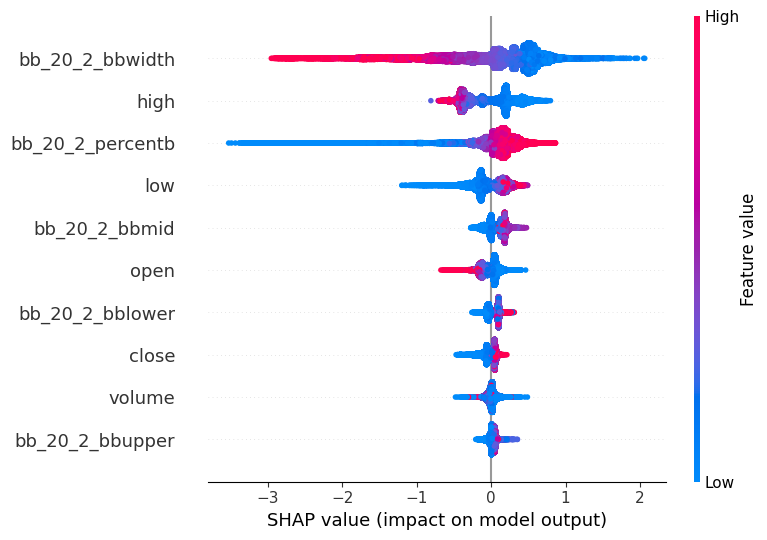

In [771]:
# Create SHAP explainer
explainer = shap.TreeExplainer(trained_clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_train)

In [772]:
# Results Primary

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22834
           1       0.33      1.00      0.50     11197

    accuracy                           0.33     34031
   macro avg       0.16      0.50      0.25     34031
weighted avg       0.11      0.33      0.16     34031

Confusion Matrix
[[    0 22834]
 [    0 11197]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [773]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_test)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_test, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_test, y_pred))

Confusion Matrix for Direct Predictions:
[[16742  6092]
 [ 5596  5601]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     22834
           1       0.48      0.50      0.49     11197

    accuracy                           0.66     34031
   macro avg       0.61      0.62      0.62     34031
weighted avg       0.66      0.66      0.66     34031



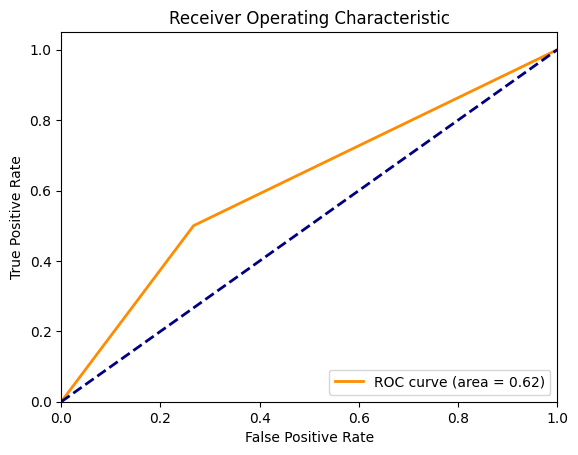

In [774]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [775]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[21783  1051]
 [10036  1161]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.68      0.95      0.80     22834
           1       0.52      0.10      0.17     11197

    accuracy                           0.67     34031
   macro avg       0.60      0.53      0.49     34031
weighted avg       0.63      0.67      0.59     34031



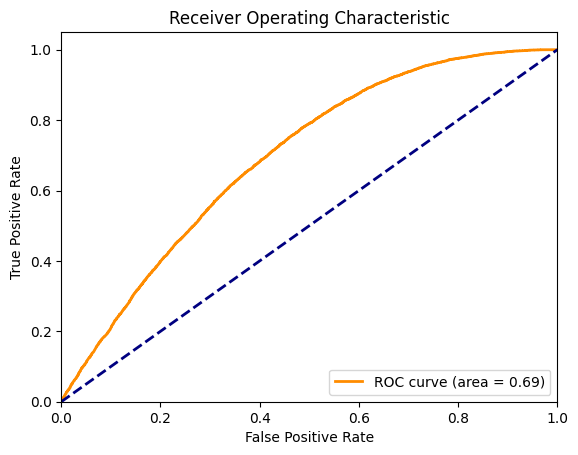

In [776]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Model Performance Changes
      Metric  Primary Model  Secondary Model  Change (%)
0  Precision         0.3290           0.5249     59.5218
1     Recall         1.0000           0.1037    -89.6312
2   F1-Score         0.4951           0.1732    -65.0263
3   Accuracy         0.3290           0.6742    104.9120
4        AUC         0.5000           0.6942     38.8423


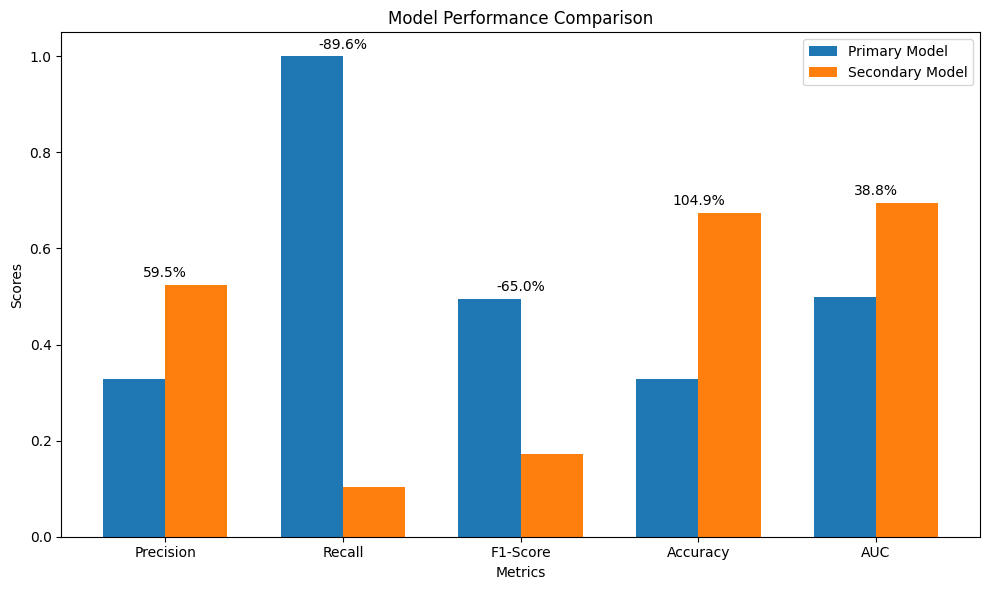

In [777]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Secondary model predictions
# Assuming clf and X_test are defined elsewhere
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)

# Calculate performance metrics for primary model
precision_primary, recall_primary, f1_primary, _ = precision_recall_fscore_support(primary_forecast['actual'], primary_forecast['pred'], average=None, labels=[1])
accuracy_primary = accuracy_score(primary_forecast['actual'], primary_forecast['pred'])
# For the primary model, since the prediction is always 1, the AUC is not applicable
auc_primary = roc_auc_score(primary_forecast['actual'], primary_forecast['pred'])

# Calculate performance metrics for secondary model
precision_secondary, recall_secondary, f1_secondary, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average=None, labels=[1])
accuracy_secondary = accuracy_score(y_test, y_pred_threshold)
auc_secondary = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC calculation

# Calculate percentage changes
precision_change = ((precision_secondary - precision_primary) / precision_primary) * 100
recall_change = ((recall_secondary - recall_primary) / recall_primary) * 100
f1_change = ((f1_secondary - f1_primary) / f1_primary) * 100
accuracy_change = ((accuracy_secondary - accuracy_primary) / accuracy_primary) * 100
auc_change = ((auc_secondary - auc_primary) / auc_primary) * 100 if auc_primary != 0 else 0

# Create a DataFrame for the changes
changes_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC'],
    'Primary Model': [precision_primary[0], recall_primary[0], f1_primary[0], accuracy_primary, auc_primary],
    'Secondary Model': [precision_secondary[0], recall_secondary[0], f1_secondary[0], accuracy_secondary, auc_secondary],
    'Change (%)': [precision_change[0], recall_change[0], f1_change[0], accuracy_change, auc_change]
})

# Print the DataFrame to the console
print("Model Performance Changes")
print(changes_df)

# Plotting the changes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(changes_df))

bar1 = ax.bar(index, changes_df['Primary Model'], bar_width, label='Primary Model')
bar2 = ax.bar(index + bar_width, changes_df['Secondary Model'], bar_width, label='Secondary Model')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(changes_df['Metric'])
ax.legend()

# Adding percentage change annotations
for i in range(len(changes_df)):
    ax.text(i + bar_width / 2, max(changes_df['Primary Model'][i], changes_df['Secondary Model'][i]) + 0.01,
            f"{changes_df['Change (%)'][i]:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Financials

In [778]:
import numpy as np
import pandas as pd

ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names

# Assuming `test_set_with_preds` DataFrame is already created as shown in your context

# Primary Model: Predictions are all 1
primary_model_profits = test_set_with_preds["profit"]

# Secondary Model: Predictions with a threshold of 0.6
secondary_model_profits = test_set_with_preds[test_set_with_preds["pred"] > 0.6]["profit"]

# Calculate mean and standard deviation for primary model
primary_mean_profit = primary_model_profits.mean()
primary_std_profit = primary_model_profits.std()

# Calculate mean and standard deviation for secondary model
secondary_mean_profit = secondary_model_profits.mean()
secondary_std_profit = secondary_model_profits.std()

# Calculate the differences
mean_profit_difference = secondary_mean_profit - primary_mean_profit
std_profit_difference = secondary_std_profit - primary_std_profit

# Print the results
print("Mean Profit Difference (Secondary - Primary):", mean_profit_difference)
print("Standard Deviation of Profit Difference (Secondary - Primary):", std_profit_difference)


Mean Profit Difference (Secondary - Primary): 0.01732942089330858
Standard Deviation of Profit Difference (Secondary - Primary): -0.0356293600267822


# Experiment 2: False Negatives

In [779]:
X_train = train_set.loc[:, columns_train]
y_train = train_set.loc[:, 'profit_binary']
y_train = y_train.astype(int)


In [780]:
X_test = test_set.loc[:, columns_train]
y_test = test_set.loc[:, 'profit_binary']
y_test = y_test.astype(int)

In [781]:
y_train.value_counts()

0    45092
1    37679
Name: profit_binary, dtype: int64

### Train Meta Model

In [782]:
from sklearn.ensemble import RandomForestClassifier
cfg = {
    "num_threads": 8,
    "boosting_type": "gbdt",
    "lambda_l1": 2.8269687100646643,
    "lambda_l2": 0.1132729746179371,
    "num_leaves": 100,
    #"num_leaves": 222,
    "feature_fraction": 0.6029600980261194,
    "bagging_fraction": 0.9924346775670325,
    "bagging_freq": 2,
    "min_child_samples": 65,
    "max_depth": 14,
    "max_bin": 136,
    "learning_rate": 0.30197097330510875,
    "importance_type": "gain"
}

clf = lgb.LGBMClassifier(seed=42)

clf.set_params(**cfg)

# clf = RandomForestClassifier(random_state=42, n_jobs=-1)
trained_clf = clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.1132729746179371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1132729746179371
[LightGBM] [Warning] feature_fraction is set=0.6029600980261194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029600980261194
[LightGBM] [Warning] bagging_fraction is set=0.9924346775670325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924346775670325
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] lambda_l1 is set=2.8269687100646643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8269687100646643


In [783]:
X_train

,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-06-25 00:00:00+00:00,17.3300,17.3300,14.8200,14.8200,614398.0000,28.0000,30.0000,16.8345,18.2607,15.4083,-0.2062,0.1694,14980.1930,9.4000,1.9100,8599.9000,0.0000,1076.7600,0.0700,2223.4800,0.0728,10143.8096,0.0624,1255.8000,0.0404,19.1050,0.0890,78.8600,0.0933,0.0000,85.3100,3.1130,0.1250,1.9110,4.0710,3.9460,3.2558,0.3479,0.0000,0.0000,-0.1349,-1.0000,9.0652,16.0090,15.5511,15.2846,33.0338,13.9257,42.7162,34.4797,13.4971,35.7754,40.1231,12.7404,32.6472,1.3435,-2.1400,16.5814,0.0200,1.0000,-12.6179,17.8705,27.7493,-213.2464,0.0000,16.0199,38.2390,54.3823,100.0000,28.5714,-71.4286,-0.1866,-0.0702,-0.0480,14.5762,16.2725,17.9688,20.8488,0.0719,0.5950,0.0543,0.1097,0.0834,0.0691,0.0641,0.0545,-0.7440,-0.1262,0.0556,-0.1660,0.0205,0.0186,-7.3646,1.4665,8.3378,133346.0000,45.0000,93271.0000,-8.4880,0.5170,7.9610,-7.5360,-7.5360,-5.6590,-5.6590,0.5340,-105.4200,0.0000,-0.0930,0.1240,0.0320,0.2130,-0.0770,-0.0020,0.1160,0.0000,0.0530,0.0000,1.0620,-0.0400,-1.0900,0.0570,0.0360,0.1850,0.1060,0.7280,0.8610,0.7300,0.1290,0.1090,0.2530,

In [784]:
ypred = trained_clf.predict(X_train)
ypred
pred_df = pd.DataFrame(data = [ypred, y_train.to_numpy()]).T
pred_df.columns = ["prediction", "target"]
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_train)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_train, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_train, y_pred))

Confusion Matrix for Direct Predictions:
[[41077  4015]
 [ 3577 34102]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     45092
           1       0.89      0.91      0.90     37679

    accuracy                           0.91     82771
   macro avg       0.91      0.91      0.91     82771
weighted avg       0.91      0.91      0.91     82771



In [785]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_train)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.8).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_train, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_train, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[44909   183]
 [20546 17133]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     45092
           1       0.99      0.45      0.62     37679

    accuracy                           0.75     82771
   macro avg       0.84      0.73      0.72     82771
weighted avg       0.82      0.75      0.73     82771



import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

# Assuming `trained_clf` is your trained model and `X_train` is your training data

# Gain-based feature importance
gain_importance = trained_clf.booster_.feature_importance(importance_type='gain')
gain_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': gain_importance})
print("Gain-based feature importance:\n", gain_importance_df)

# Split-based feature importance
split_importance = trained_clf.booster_.feature_importance(importance_type='split')
split_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': split_importance})
print("Split-based feature importance:\n", split_importance_df)

# Permutation importance (optional and more computationally expensive)
perm_importance = permutation_importance(trained_clf, X_train, y_train, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importance.importances_mean})
print("Permutation feature importance:\n", perm_importance_df)

# Plotting feature importance (optional)
import matplotlib.pyplot as plt

# Plot gain-based feature importance
gain_importance_df = gain_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(gain_importance_df['feature'], gain_importance_df['importance'])
plt.xlabel('Gain Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Gain')
plt.gca().invert_yaxis()
plt.show()

# Plot split-based feature importance
split_importance_df = split_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(split_importance_df['feature'], split_importance_df['importance'])
plt.xlabel('Split Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Split')
plt.gca().invert_yaxis()
plt.show()


# Get top 20 features by Gain-based importance
top20_gain = gain_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Gain-based importance:\n", top20_gain)

# Get top 20 features by Split-based importance
top20_split = split_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Split-based importance:\n", top20_split)

# Get top 20 features by Permutation importance
top20_perm = perm_importance_df.sort_values(by='importance', ascending=False).head(50)
print("Top 20 features by Permutation importance:\n", top20_perm)

# Find the common top 20 features across all methods
common_top20_features = set(top20_gain['feature']).intersection(top20_split['feature'], top20_perm['feature'])
print("Top 20 features that scored well in all methods:\n", common_top20_features)

# Convert common top 20 features to DataFrame for display
common_top20_features_df = pd.DataFrame(common_top20_features, columns=['feature'])
print("Common top 20 features across all methods:\n", common_top20_features_df)


# Create SHAP explainer
explainer = shap.TreeExplainer(trained_clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot for the first class (if binary classification)
shap.summary_plot(shap_values[1], X_train)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_train.iloc[0])


# Test

In [786]:
# Results Primary

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22834
           1       0.33      1.00      0.50     11197

    accuracy                           0.33     34031
   macro avg       0.16      0.50      0.25     34031
weighted avg       0.11      0.33      0.16     34031

Confusion Matrix
[[    0 22834]
 [    0 11197]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [787]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
# Direct class predictions
y_pred = clf.predict(X_test)
# Confusion matrix
print("Confusion Matrix for Direct Predictions:")
print(confusion_matrix(y_test, y_pred))
# Precision, recall, f1-score
print("\nClassification Report for Direct Predictions:")
print(classification_report(y_test, y_pred))

Confusion Matrix for Direct Predictions:
[[17992  4842]
 [ 6323  4874]]

Classification Report for Direct Predictions:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76     22834
           1       0.50      0.44      0.47     11197

    accuracy                           0.67     34031
   macro avg       0.62      0.61      0.61     34031
weighted avg       0.66      0.67      0.67     34031



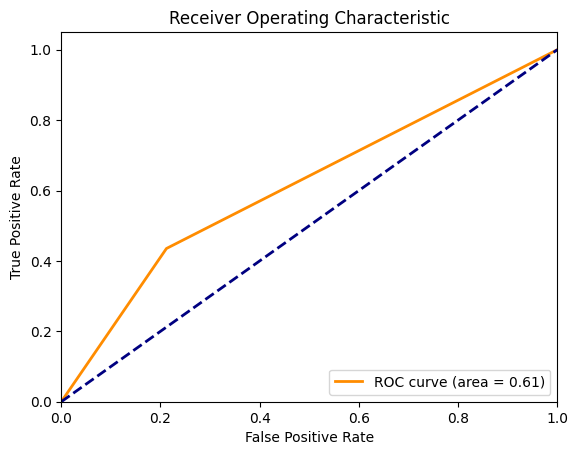

In [788]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [789]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.8 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.8 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.8 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.8 Threshold:
[[19852  2982]
 [ 7983  3214]]

Classification Report with 0.8 Threshold:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78     22834
           1       0.52      0.29      0.37     11197

    accuracy                           0.68     34031
   macro avg       0.62      0.58      0.58     34031
weighted avg       0.65      0.68      0.65     34031



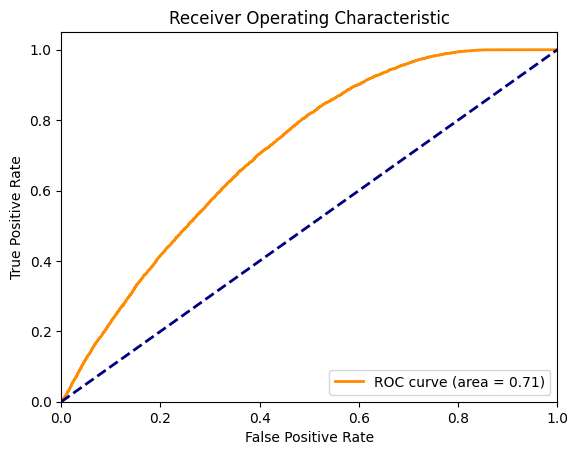

In [790]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [791]:
# Predicting probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Applying threshold of 0.9 to determine class predictions
y_pred_threshold = (y_pred_proba >= 0.9).astype(int)
# Confusion matrix
print("Confusion Matrix with 0.9 Threshold:")
print(confusion_matrix(y_test, y_pred_threshold))
# Precision, recall, f1-score
print("\nClassification Report with 0.9 Threshold:")
print(classification_report(y_test, y_pred_threshold))

Confusion Matrix with 0.9 Threshold:
[[22718   116]
 [11104    93]]

Classification Report with 0.9 Threshold:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80     22834
           1       0.44      0.01      0.02     11197

    accuracy                           0.67     34031
   macro avg       0.56      0.50      0.41     34031
weighted avg       0.60      0.67      0.54     34031



Model Performance Changes
      Metric  Primary Model  Secondary Model  Change (%)
0  Precision         0.3290           0.5187     57.6549
1     Recall         1.0000           0.2870    -71.2959
2   F1-Score         0.4951           0.3696    -25.3591
3   Accuracy         0.3290           0.6778    106.0016
4        AUC         0.5000           0.7108     42.1676


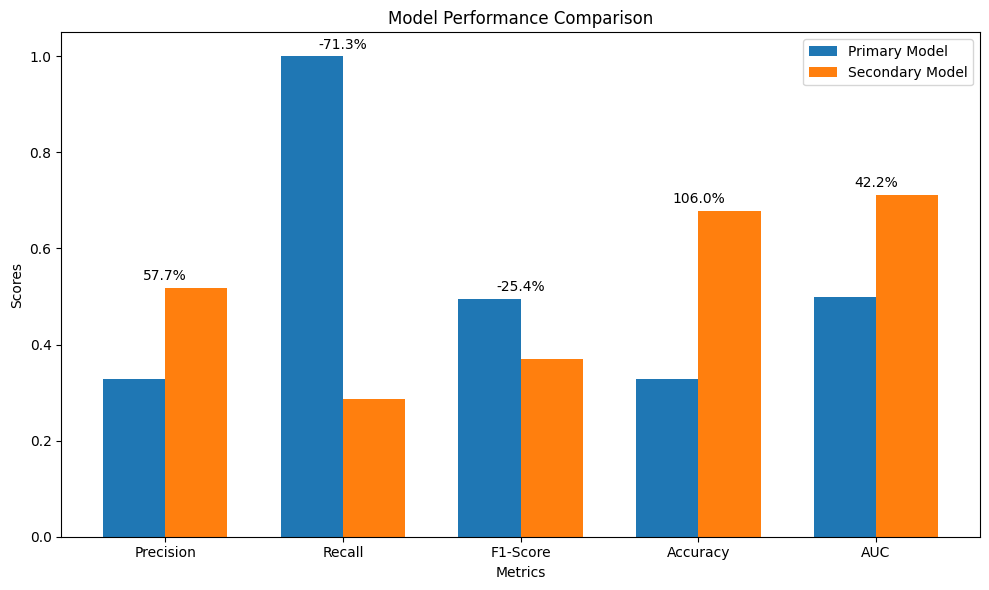

In [792]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

primary_forecast = pd.DataFrame(y_test)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Secondary model predictions
# Assuming clf and X_test are defined elsewhere
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_pred_proba >= 0.6).astype(int)

# Calculate performance metrics for primary model
precision_primary, recall_primary, f1_primary, _ = precision_recall_fscore_support(primary_forecast['actual'], primary_forecast['pred'], average=None, labels=[1])
accuracy_primary = accuracy_score(primary_forecast['actual'], primary_forecast['pred'])
# For the primary model, since the prediction is always 1, the AUC is not applicable
auc_primary = roc_auc_score(primary_forecast['actual'], primary_forecast['pred'])

# Calculate performance metrics for secondary model
precision_secondary, recall_secondary, f1_secondary, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average=None, labels=[1])
accuracy_secondary = accuracy_score(y_test, y_pred_threshold)
auc_secondary = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC calculation

# Calculate percentage changes
precision_change = ((precision_secondary - precision_primary) / precision_primary) * 100
recall_change = ((recall_secondary - recall_primary) / recall_primary) * 100
f1_change = ((f1_secondary - f1_primary) / f1_primary) * 100
accuracy_change = ((accuracy_secondary - accuracy_primary) / accuracy_primary) * 100
auc_change = ((auc_secondary - auc_primary) / auc_primary) * 100 if auc_primary != 0 else 0

# Create a DataFrame for the changes
changes_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'AUC'],
    'Primary Model': [precision_primary[0], recall_primary[0], f1_primary[0], accuracy_primary, auc_primary],
    'Secondary Model': [precision_secondary[0], recall_secondary[0], f1_secondary[0], accuracy_secondary, auc_secondary],
    'Change (%)': [precision_change[0], recall_change[0], f1_change[0], accuracy_change, auc_change]
})

# Print the DataFrame to the console
print("Model Performance Changes")
print(changes_df)

# Plotting the changes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(changes_df))

bar1 = ax.bar(index, changes_df['Primary Model'], bar_width, label='Primary Model')
bar2 = ax.bar(index + bar_width, changes_df['Secondary Model'], bar_width, label='Secondary Model')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(changes_df['Metric'])
ax.legend()

# Adding percentage change annotations
for i in range(len(changes_df)):
    ax.text(i + bar_width / 2, max(changes_df['Primary Model'][i], changes_df['Secondary Model'][i]) + 0.01,
            f"{changes_df['Change (%)'][i]:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Financial


In [793]:
test_set

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2
82771,2020-01-02 00:00:00+00:00,33.2500,33.3700,31.5400,32.2700,841224.0000,37.0000,27.0000,33.5752,34.8137,32.3368,-0.0270,0.0738,21706.5130,3.6000,1.8000,15452.4000,6945.0100,3257.8501,0.0183,9092.1904,0.0219,28868.8008,0.0203,1524.5000,0.0212,17.9660,0.0478,61.1800,0.0800,6985.4702,96.8500,1.8820,1.4950,1.6710,2.3410,0.8460,1.8367,0.2162,1.0000,0.0000,-0.0278,-0.5355,3.2932,32.8170,32.5115,32.3914,45.8762,6.7500,48.2091,29.1367,11.0821,41.6997,22.4622,14.0992,37.7583,1.0627,-0.9900,33.4041,0.0200,1.0000,-2.9765,19.4428,31.3514,-163.9097,0.0000,32.9051,20.1335,19.1725,100.0000,42.8571,-57.1429,-0.0390,-0.0144,-0.0097,32.0590,33.0025,33.9460,5.7180,0.1118,0.5787,0.0133,0.0237,0.0172,0.0180,0.0158,0.0133,-0.0895,-0.0274,0.0093,0.4501,0.0058,0.0144,-2.5427,11.6219,0.9619,0.0542,1.0000,11854.0000,40.0000,14318.0000,55.5930,0.5140,8.1490,13.5830,14.4430,14.4430,14.4430,6.2320,11.7260,0.0000,0.4490,0.6350,0.6100,0.6350,0.5690,0.4770,0.1970,0.2120,0.2520,0.2060,0.2150,0.1900,0.2150,0.0000,0.0000,0.1870,0.8370,0.1630,0.1570,0.1630,0.0800,0.0830,0.2910,0.0000,0.0000,0.1230,0.6600,0.0100,0.0000,0.3760,0.0000,0.0000,0.3730,0.9450,13.0930,0.1890,0.3410,0.1870,0.5170,13.9570,17.6070,0.0000,0.0000,0.0000,0.0000,0.0000,0.2940,6.9120,4.5720,0.3740,0.4460,0.0

In [794]:
ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names


In [795]:
# profit factor whole dataset
print("Test set base PF:")
print(sum(test_set_with_preds[test_set_with_preds["profit"] > 0]["profit"]) / abs(sum(test_set_with_preds[test_set_with_preds["profit"] <= 0]["profit"])))
print("")

# profit factor with model predictions
print("Test set with > 0.5 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.5]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.8 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.8]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

print("Test set with > 0.9 PF:")
pred_set = test_set_with_preds[test_set_with_preds["pred"] > 0.9]
print(sum(pred_set[pred_set["profit"] > 0]["profit"]) / abs(sum(pred_set[pred_set["profit"] <= 0]["profit"])))
print("")

Test set base PF:
0.4987016278420532

Test set with > 0.5 PF:
0.9363870185358433

Test set with > 0.8 PF:
1.103350253749982

Test set with > 0.9 PF:
0.7457718060734574



In [796]:
len(test_set_with_preds)

34031

In [797]:
test_set_with_preds

,date,open,high,low,close,volume,from_earnings,to_earnings,bb_20_2_bbmid,bb_20_2_bbupper,bb_20_2_bblower,bb_20_2_percentb,bb_20_2_bbwidth,GDP,Unemployment,Inflation,M2,CryptoMarketCap,SP500,SP500_Vol,NASDAQ,NASDAQ_Vol,DowJones,DowJones_Vol,Gold,Gold_Daily_Vol,Silver,Silver_Daily_Vol,CrudeOil,CrudeOil_Vol,BTC,USDIndex,Treasury_Yield1,Treasury_Yield2,Treasury_Yield3,Treasury_Yield4,yield_curve_spread,treasury_yield1_ma30,treasury_yield1_vol,SP500_new_highs,SP500_new_lows,log_return,BOP,NATR_4,WMA_4,DEMA_4,TEMA_4,ADX_4,DMP_4,DMN_4,ADX_6,DMP_6,DMN_6,ADX_8,DMP_8,DMN_8,ATRr_4,MOM_4,KAMA_4_2_30,PSARaf_0.02_0.2,PSARr_0.02_0.2,ROC_4,RSI_4,RSI_8,CCI_14_0.015,CDL_DOJI_10_0.1,EMA_4,STOCHk_5_3_3,STOCHd_5_3_3,AROOND_14,AROONU_14,AROONOSC_14,HMA_2,HMA_4,HMA_8,BBL_4_2.0,BBM_4_2.0,BBU_4_2.0,BBB_4_2.0,BBP_4_2.0,DPO_8,STDEV_1,STDEV_2,STDEV_3,STDEV_4,STDEV_6,STDEV_8,PROC,min_ret,max_ret,autocorr_1,lag_target,std,z_score,garch_vol_close,frac_diff_close,profit,profit_binary,gvkey,gsector,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,evm_Median,pcf_Median,pe_exi_Median,pe_inc_Median,pe_op_basic_Median,pe_op_dil_Median,ps_Median,ptb_Median,efftax_Median,GProf_Median,aftret_eq_Median,aftret_equity_Median,aftret_invcapx_Median,gpm_Median,npm_Median,opmad_Median,opmbd_Median,pretret_earnat_Median,pretret_noa_Median,ptpm_Median,roa_Median,roce_Median,roe_Median,capital_ratio_Median,equity_invcap_Median,debt_invcap_Median,totdebt_invcap_Median,invt_act_Median,rect_act_Median,fcf_ocf_Median,ocf_lct_Median,cash_debt_Median,cash_lt_Median,cfm_Median,short_debt_Median,profit_lct_Median,curr_debt_Median,debt_ebitda_Median,dltt_be_Median,int_debt_Median,int_totdebt_Median,lt_debt_Median,lt_ppent_Median,de_ratio_Median,debt_assets_Median,debt_at_Median,debt_capital_Median,intcov_Median,intcov_ratio_Median,cash_conversion_Median,cash_ratio_Median,curr_ratio_Median,quick_ratio_Median,at_turn_Median,inv_turn_Median,pay_turn_Median,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PSAR_0.02_0.2,pred
0,2020-01-02 00:00:00+00:00,33.2500,33.3700,31.5400,32.2700,841224.0000,37.0000,27.0000,33.5752,34.8137,32.3368,-0.0270,0.0738,21706.5130,3.6000,1.8000,15452.4000,6945.0100,3257.8501,0.0183,9092.1904,0.0219,28868.8008,0.0203,1524.5000,0.0212,17.9660,0.0478,61.1800,0.0800,6985.4702,96.8500,1.8820,1.4950,1.6710,2.3410,0.8460,1.8367,0.2162,1.0000,0.0000,-0.0278,-0.5355,3.2932,32.8170,32.5115,32.3914,45.8762,6.7500,48.2091,29.1367,11.0821,41.6997,22.4622,14.0992,37.7583,1.0627,-0.9900,33.4041,0.0200,1.0000,-2.9765,19.4428,31.3514,-163.9097,0.0000,32.9051,20.1335,19.1725,100.0000,42.8571,-57.1429,-0.0390,-0.0144,-0.0097,32.0590,33.0025,33.9460,5.7180,0.1118,0.5787,0.0133,0.0237,0.0172,0.0180,0.0158,0.0133,-0.0895,-0.0274,0.0093,0.4501,0.0058,0.0144,-2.5427,11.6219,0.9619,0.0542,1.0000,11854.0000,40.0000,14318.0000,55.5930,0.5140,8.1490,13.5830,14.4430,14.4430,14.4430,6.2320,11.7260,0.0000,0.4490,0.6350,0.6100,0.6350,0.5690,0.4770,0.1970,0.2120,0.2520,0.2060,0.2150,0.1900,0.2150,0.0000,0.0000,0.1870,0.8370,0.1630,0.1570,0.1630,0.0800,0.0830,0.2910,0.0000,0.0000,0.1230,0.6600,0.0100,0.0000,0.3760,0.0000,0.0000,0.3730,0.9450,13.0930,0.1890,0.3410,0.1870,0.5170,13.9570,17.6070,0.0000,0.0000,0.0000,0.0000,0.0000,0.2940,6.9120,4.5720,0.3740,0.4460,0.

In [798]:
import numpy as np
import pandas as pd

ypred = trained_clf.predict_proba(X_test)[:,1]
column_names = test_set.columns.to_list()
column_names.append("pred")
test_set_with_preds = pd.DataFrame(data = np.c_[test_set.to_numpy(), ypred])
test_set_with_preds.columns = column_names

# Assuming `test_set_with_preds` DataFrame is already created as shown in your context

# Primary Model: Predictions are all 1
primary_model_profits = test_set_with_preds["profit"]

# Secondary Model: Predictions with a threshold of 0.6
secondary_model_profits = test_set_with_preds[test_set_with_preds["pred"] > 0.7]["profit"]

# Calculate mean and standard deviation for primary model
primary_mean_profit = primary_model_profits.mean()
primary_std_profit = primary_model_profits.std()

# Calculate mean and standard deviation for secondary model
secondary_mean_profit = secondary_model_profits.mean()
secondary_std_profit = secondary_model_profits.std()

# Calculate the differences
mean_profit_difference = secondary_mean_profit - primary_mean_profit
std_profit_difference = secondary_std_profit - primary_std_profit

# Print the results
print("Mean Profit Difference (Secondary - Primary):", mean_profit_difference)
print("Standard Deviation of Profit Difference (Secondary - Primary):", std_profit_difference)


Mean Profit Difference (Secondary - Primary): 0.03745908247286637
Standard Deviation of Profit Difference (Secondary - Primary): -0.00472850363699899


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

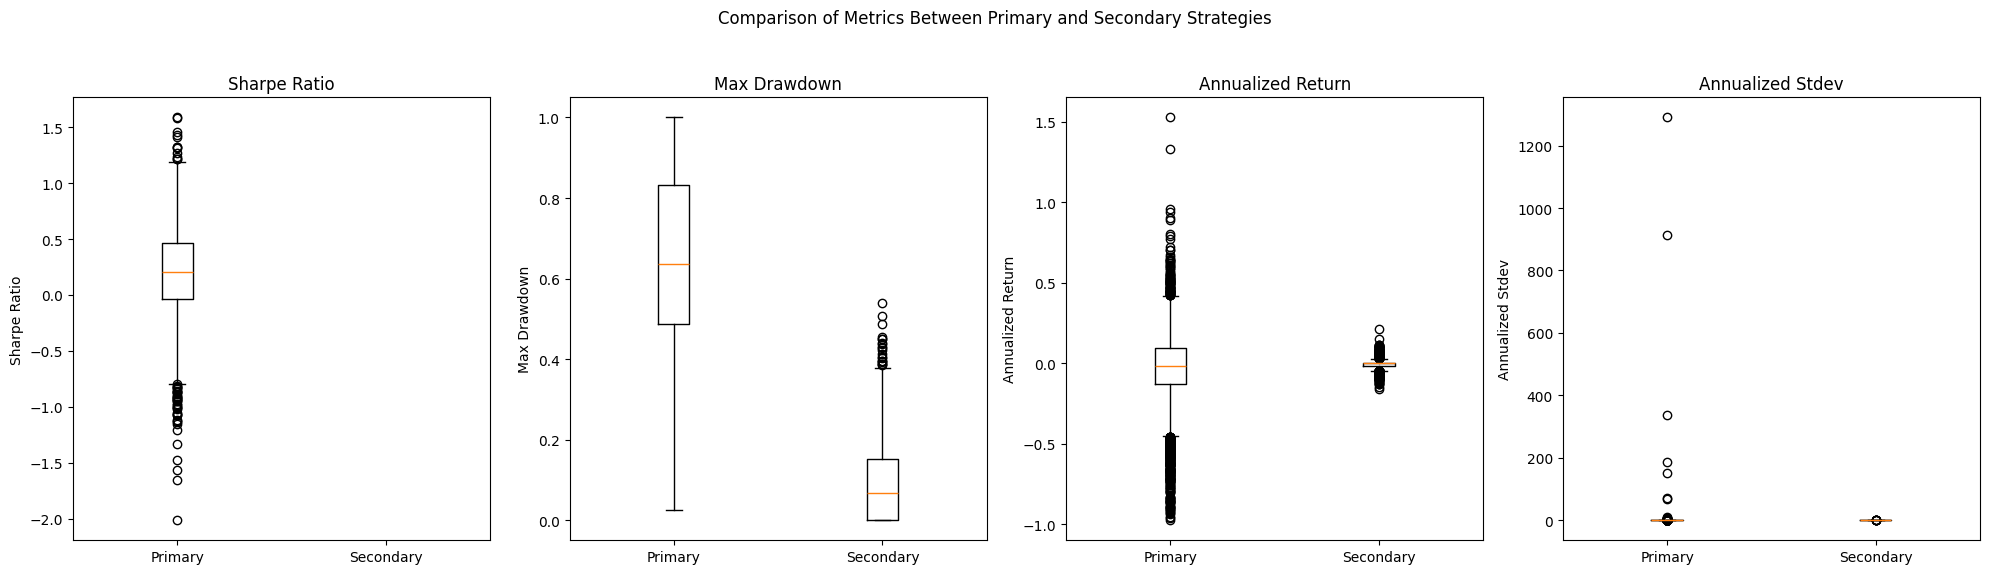

In [801]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define function to calculate daily returns
def calculate_daily_returns(prices):
    return prices['prccd'].pct_change().fillna(0)

# Define function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

# Define function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdowns = (running_max - cumulative_returns) / running_max
    return drawdowns.max()

# Define function to calculate annualized returns
def calculate_annualized_returns(returns):
    cumulative_return = (1 + returns).prod()
    return cumulative_return ** (252 / len(returns)) - 1

# Define function to calculate annualized standard deviation
def calculate_annualized_stdev(returns):
    return np.std(returns) * np.sqrt(252)

# Merge test_set_with_preds with raw to include 'cusip' and 'exit_date'
merged_trades = pd.merge(
    test_set_with_preds,
    raw[['date', 'exit_date', 'gvkey', 'cusip']],
    on=['date', 'gvkey'],
    how='left'
)

# Determine the overall date range from the entire test_set_with_preds
overall_start_date = merged_trades['date'].min()
overall_end_date = merged_trades['exit_date'].max()

# Initialize lists to store the metrics for boxplots
metrics_primary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}
metrics_secondary = {'Sharpe Ratio': [], 'Max Drawdown': [], 'Annualized Return': [], 'Annualized Stdev': []}

# Iterate over each asset in the merged trades
for asset, group in merged_trades.groupby(['gvkey', 'cusip']):
    cusip = group['cusip'].iloc[0]

    # Load daily price data for the asset
    price_data_path = f"data/trading_daily/{cusip}.csv"
    if os.path.exists(price_data_path):
        price_data = pd.read_csv(price_data_path, parse_dates=['datadate'])
        price_data.set_index('datadate', inplace=True)

        # Calculate daily returns
        price_data['daily_return'] = calculate_daily_returns(price_data)

        # Create a complete daily return series for the asset from the overall date range
        all_dates = pd.date_range(start=overall_start_date, end=overall_end_date, freq='B')
        asset_returns_primary = pd.DataFrame(index=all_dates)
        asset_returns_primary['daily_return'] = 0.0

        # Update daily returns based on the price data for all trading days
        asset_returns_primary.update(price_data['daily_return'])

        # For the primary strategy: Include returns during the trade period
        for _, trade in group.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            if not trade_dates.empty:
                asset_returns_primary.loc[trade_dates, 'daily_return'] = price_data.loc[trade_dates, 'daily_return']

        # Calculate metrics for the primary strategy
        metrics_primary['Sharpe Ratio'].append(calculate_sharpe_ratio(asset_returns_primary['daily_return']))
        metrics_primary['Max Drawdown'].append(calculate_max_drawdown(asset_returns_primary['daily_return']))
        metrics_primary['Annualized Return'].append(calculate_annualized_returns(asset_returns_primary['daily_return']))
        metrics_primary['Annualized Stdev'].append(calculate_annualized_stdev(asset_returns_primary['daily_return']))

        # For the secondary strategy: Filter trades with pred > threshold
        secondary_trades = group[group['pred'] > 0.6]
        asset_returns_secondary = pd.DataFrame(index=all_dates)
        asset_returns_secondary['daily_return'] = 0.0

        for _, trade in secondary_trades.iterrows():
            trade_dates = pd.date_range(start=trade['date'], end=trade['exit_date'], freq='B')
            trade_dates = trade_dates.intersection(price_data.index)  # Ensure dates are in the price data
            if not trade_dates.empty:
                asset_returns_secondary.loc[trade_dates, 'daily_return'] = price_data.loc[trade_dates, 'daily_return']

        # Calculate metrics for the secondary strategy
        metrics_secondary['Sharpe Ratio'].append(calculate_sharpe_ratio(asset_returns_secondary['daily_return']))
        metrics_secondary['Max Drawdown'].append(calculate_max_drawdown(asset_returns_secondary['daily_return']))
        metrics_secondary['Annualized Return'].append(calculate_annualized_returns(asset_returns_secondary['daily_return']))
        metrics_secondary['Annualized Stdev'].append(calculate_annualized_stdev(asset_returns_secondary['daily_return']))

# Plotting boxplots for each metric
metrics = ['Sharpe Ratio', 'Max Drawdown', 'Annualized Return', 'Annualized Stdev']


The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


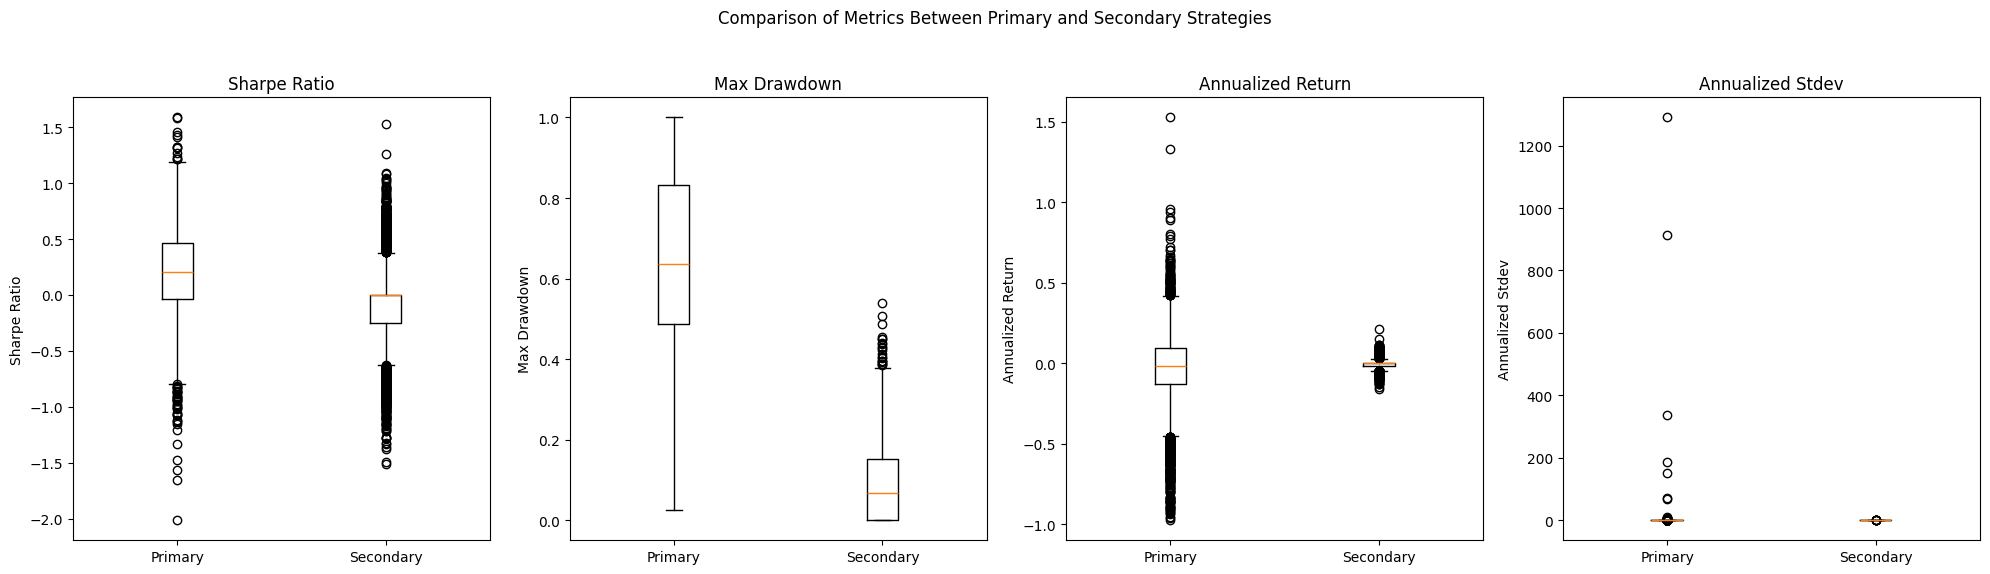

In [806]:

# Fill NaN values with 0 in primary metrics
for metric in metrics_primary:
    metrics_primary[metric] = np.nan_to_num(metrics_primary[metric], nan=0.0)

# Fill NaN values with 0 in secondary metrics
for metric in metrics_secondary:
    metrics_secondary[metric] = np.nan_to_num(metrics_secondary[metric], nan=0.0)

fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 6))
fig.suptitle('Comparison of Metrics Between Primary and Secondary Strategies')

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.boxplot([metrics_primary[metric], metrics_secondary[metric]], labels=['Primary', 'Secondary'])
    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [807]:
# Convert the metrics dictionaries to DataFrames
primary_metrics_df = pd.DataFrame(metrics_primary)
secondary_metrics_df = pd.DataFrame(metrics_secondary)

# Fill NaN values with 0 (in case it hasn't been done yet)
primary_metrics_df = primary_metrics_df.fillna(0)
secondary_metrics_df = secondary_metrics_df.fillna(0)

# Output descriptive statistics
print("Primary Metrics Descriptive Statistics:")
print(primary_metrics_df.describe())

print("\nSecondary Metrics Descriptive Statistics:")
print(secondary_metrics_df.describe())

Primary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3975.0000     3975.0000          3975.0000         3975.0000
mean         0.1985        0.6539            -0.0395            1.3056
std          0.3872        0.2109             0.2410           25.9605
min         -2.0141        0.0262            -0.9753            0.0198
25%         -0.0396        0.4863            -0.1271            0.3473
50%          0.2095        0.6361            -0.0163            0.4691
75%          0.4633        0.8334             0.0922            0.6603
max          1.5875        1.0000             1.5250         1290.1836

Secondary Metrics Descriptive Statistics:
       Sharpe Ratio  Max Drawdown  Annualized Return  Annualized Stdev
count     3975.0000     3975.0000          3975.0000         3975.0000
mean        -0.0801        0.0867            -0.0056            0.0418
std          0.3774        0.0953             0.0273            0

In [ ]:
def save_model_sklearn(model_name: str):
    """
    Saves models from sklearn to filesystem.

    Args:
        model (sklearn model): Sklearn model.
        path (string): The path to save the model to.
        model_name (string): The name of the model.
    """
    joblib.dump(trained_clf, f'../data/processed/stockscreener/ml_model/{model_name}.joblib')